<a href="https://colab.research.google.com/github/josefernandezest98/training/blob/main/Fruit_Thresholding/fruit_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Thresholding

The demand for intelligent agriculture is increasing due to the continuous impact of world
food and environmental crises. In particular, fruit detection and segmentation is the main challenge to afford nowadays. The essay referenced in [1]
summarizes the computer vision's difficulties in fruit environments. It is highly recommendable to take a look at the article before running this notebook, although they both are independet and there is no real need for a perfect understanding of the notebook.



In [6]:
# Libraries
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# function: plots an image with MatPlotLib
def show_img(image):
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.imshow(img2,cmap='gray')
        plt.show()

In [8]:
# Download images and labels
!wget https://raw.githubusercontent.com/josefernandezest98/training/main/Fruit_Thresholding/mandarinas.jpg
!wget https://raw.githubusercontent.com/josefernandezest98/training/main/Fruit_Thresholding/labels_kitti.txt

--2023-09-14 08:52:16--  https://raw.githubusercontent.com/josefernandezest98/training/main/Fruit_Thresholding/mandarinas.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109967 (107K) [image/jpeg]
Saving to: ‘mandarinas.jpg.1’

mandarinas.jpg.1    100%[===================>] 107.39K  --.-KB/s    in 0.01s   

2023-09-14 08:52:16 (9.59 MB/s) - ‘mandarinas.jpg.1’ saved [109967/109967]

--2023-09-14 08:52:16--  https://raw.githubusercontent.com/josefernandezest98/training/main/Fruit_Thresholding/labels_kitti.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaitin

In [9]:
fichero = 'labels_kitti.txt'
df_labels = pd.DataFrame()

with open(fichero) as X:

        for line in X:

            linea = line.split(" ")
            x_min = float(linea[4])
            y_min = float(linea[5])
            x_max = float(linea[6])
            y_max = float(linea[7])
            prob = float(linea[-1][:-1])
            inner = pd.DataFrame({'x_min': [x_min], 'y_min': [y_min], 'x_max': [x_max],
                                  'y_max': [y_max]})

            df_labels = pd.concat([df_labels,inner],ignore_index=True)

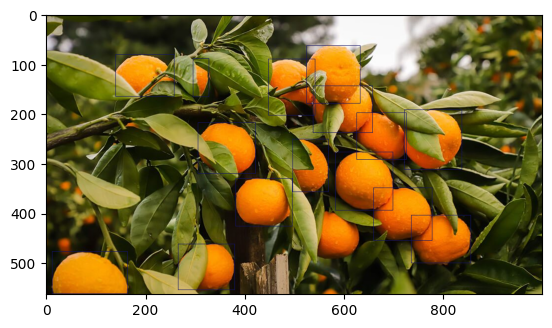

In [10]:
image_cv = cv2.imread('mandarinas.jpg')

for _, r in df_labels.iterrows():

        x_min = round(r['x_min'])
        x_max = round(r['x_max'])
        y_min = round(r['y_min'])
        y_max = round(r['y_max'])
        image_cv = cv2.rectangle(image_cv,(int(x_min),int(y_min)), \
                                 (int(x_max),int(y_max)),(100,20,20), \
                                 thickness=1)

show_img(image_cv)


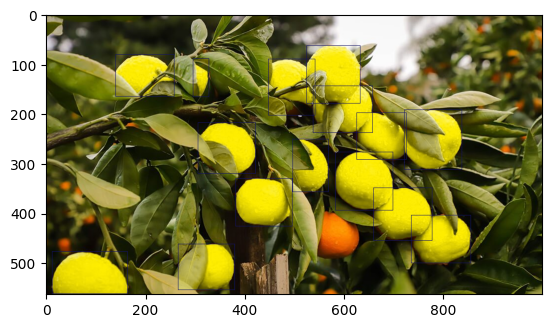

In [11]:
for _, r in df_labels.iterrows():

        x_min = round(r['x_min'])
        x_max = round(r['x_max'])
        y_min = round(r['y_min'])
        y_max = round(r['y_max'])

        bbox = image_cv[y_min:y_max,x_min:x_max]
        hsv_bbox = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)

        # mask = cv2.inRange(bbox, (18, 40, 99), (27, 255,255))
        ret, mask = cv2.threshold(bbox[:, :,2], 65, 255, cv2.THRESH_BINARY)

        imask = mask > 0

        indices = np.where(imask==1)
        bbox[indices[0], indices[1], :] = [0, 234, 255]

        hsv_bbox_new = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)
        hsv_bbox[indices[0], indices[1], 0] = np.array(hsv_bbox_new[indices[0], indices[1], 0])

        bbox_new = cv2.cvtColor(hsv_bbox, cv2.COLOR_HSV2BGR)
        image_cv[y_min:y_max,x_min:x_max] = bbox_new

show_img(image_cv)



---



# References

[1] Yunchao Tang, Jiajun Qiu, Yunqi Zhang, Dongxiao Wu, Yuhong Cao, Kexin Zhao, Lixue Zhu, *Optimization strategies of fruit detection to overcome the challenge of unstructured background in feld orchard environment: a review*